**COURSE: PRDL/MLLB**

**PROJECT: Deep Learning**

**TEACHER: Luis Hernández Gómez**

**AUTHORS: MARONE Mamadou / RACHIDI Inass**

**NOTEBOOK: TRANSFORMER ARCHITECTURE (Attention is all what you need)**

# SETUP

## INSTALLING MODULES

In [ ]:
%%capture
!pip install tensorflow
!pip install tqdm

## IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Layer, Embedding, MultiHeadAttention, Dropout, LayerNormalization, Conv1D
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#  Load and Prepare Data

In [ ]:
# os.chdir(r"C:\Users\maron\OneDrive\02-Documents\00.ETUDES\00.ECOLE_D_INGE\00.CYCLE_ING_FORMATION_INIT\00.3EME_ANNEE_INIT\00.A_COURS\00.PRDL\06.PROJECTS")

In [ ]:
df_cleaned = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PROJET_DL_MLLB/DATA/CLEANED/corpus_cleaned.csv")
df_cleaned.head(3)

,category,title,body,text
0,ARTS & CULTURE,model agenc enabl sexual predat year former ag...,octob carolyn kramer receiv disturb phone call...,model agenc enabl sexual predat year former ag...
1,ARTS & CULTURE,actor jeff hiller talk bright color bold patte...,week talk actor jeff hiller hit broadway play ...,actor jeff hiller talk bright color bold patte...
2,ARTS & CULTURE,new yorker cover put trump hole racist comment,new yorker take presid donald trump ask u woul...,new yorker cover put trump hole racist comment...


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df_cleaned['encoded_labels'] = label_encoder.fit_transform(df_cleaned['category'])

In [ ]:
# Split the data into features and labels
X = df_cleaned['text']
y = df_cleaned['encoded_labels']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Text pre-processing: Tokenize and Pad Text Data

In [ ]:
# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words = max_words, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

In [ ]:
# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad sequences for equal length
max_length = 500
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding = 'post', truncating = 'post')
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding = 'post', truncating = 'post')

# TRANSFORMER Model

In [ ]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Conv1D(filters=embed_dim, kernel_size=1, activation='relu')
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Build the transformer model
embedding_dim = 50
num_heads = 5
ff_dim = 32

# Number of classes
num_classes = len(np.unique(y_train))

In [ ]:
inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embedding_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)

x = GlobalAveragePooling1D()(x)
x = Dense(20, activation = "relu")(x)
x = Dropout(0.1)(x)
x = Dense(num_classes, activation = "softmax")(x)

model = Model(inputs=inputs, outputs=x)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 50)           525000    
 ng_6 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_5 (Trans  (None, 500, 50)           53550     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 20)                1020

In [ ]:
# Compile the model
model.compile(optimizer = Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Display the model summary
model.summary()

# TRAINING

In [ ]:
epochs = 40
batch_size = 5

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes = num_classes)
y_test_one_hot = to_categorical(y_test, num_classes = num_classes)

W notice that the batch size affect a lot the accuracy :
    - 0.45 of accuracy with 100
    - 0.50 of accuracy with 50
    - 0.58 of accuracy with 30
Number of epoch:
    - with batch size of 30 - epoch of 30 : 62%
    

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with integer-encoded labels and EarlyStopping callback
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2)

Epoch 1/40
1101/1101 [==============================] - 66s 57ms/step - loss: 1.8919 - accuracy: 0.3788 - val_loss: 1.0896 - val_accuracy: 0.6766
Epoch 2/40
1101/1101 [==============================] - 20s 18ms/step - loss: 0.8320 - accuracy: 0.7542 - val_loss: 0.9623 - val_accuracy: 0.7267
Epoch 3/40
1101/1101 [==============================] - 16s 15ms/step - loss: 0.4345 - accuracy: 0.8771 - val_loss: 0.9333 - val_accuracy: 0.7456
Epoch 4/40
1101/1101 [==============================] - 15s 14ms/step - loss: 0.2286 - accuracy: 0.9322 - val_loss: 1.1212 - val_accuracy: 0.7442
Epoch 5/40
1101/1101 [==============================] - 12s 11ms/step - loss: 0.1452 - accuracy: 0.9555 - val_loss: 1.3900 - val_accuracy: 0.7369
Epoch 6/40
1101/1101 [==============================] - 13s 12ms/step - loss: 0.0873 - accuracy: 0.9729 - val_loss: 1.5971 - val_accuracy: 0.7275
Epoch 7/40
1101/1101 [==============================] - 12s 11ms/step - loss: 0.0685 - accuracy: 0.9809 - val_loss: 1.7786 -

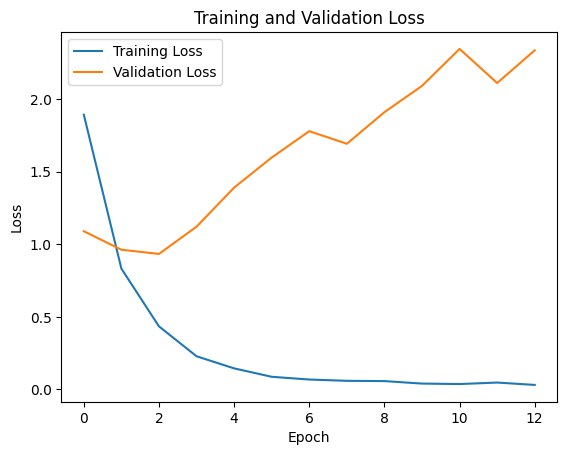

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss values
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

43/43 [==============================] - 0s 6ms/step - loss: 0.9333 - accuracy: 0.7456
Test Loss: 0.9332787394523621
Test Accuracy: 0.7456395626068115


In [ ]:
# Evaluate the model on the test set
y_pred = model.predict_classes(X_test_padded)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

# Extract precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1_score)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()